!sudo apt-get install curl git  

!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [1]:
import re
from konlpy.tag import Mecab
from packages import utils # package 폴더에 utils라는 script에 있는 모듈을 불러옵니다.


from glob import  glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

## Step 1. 데이터 로드

로드하는 데이터 관련 사이트 : [링크](https://sites.google.com/site/koreanparalleldata/)

해당 데이터는 한국인 고등학생 대상 영어 번역 데이터로 다양한 종류의 주제를 가지고 만들어졌습니다.

주제 
- 뉴스 기사
- 짧은 스토리
- 편지
- 광고

In [3]:
train_data_path = glob("./data/train/*")
test_data_path = glob("./data/test/*")
dev_data_path = glob("./data/dev/*")

def data_load(data_path):
    result = []
    for setences in data_path:
        with open(setences) as f:
            result += [f.readlines()]
    en, ko = result        
    data = pd.DataFrame({"en":en, "ko":ko})
    return data

train = data_load(train_data_path)
test = data_load(test_data_path)
dev = data_load(dev_data_path)

cp_train = train.copy()
cp_test = test.copy()
cp_dev = dev.copy()

print(f"훈련 데이터 개수 : {cp_train.shape[0]}")
print(f"검증 데이터 개수 : {cp_dev.shape[0]}")
print(f"테스트 데이터 개수 : {cp_test.shape[0]}")

훈련 데이터 개수 : 94123
검증 데이터 개수 : 1000
테스트 데이터 개수 : 2000


## Step 2. 데이터 정제

### 중복 데이터 제거

In [4]:
cp_train = cp_train.drop_duplicates("en", keep = "first")
cp_train = cp_train.drop_duplicates("ko", keep = "first").reset_index()

cp_test = cp_test.drop_duplicates("en", keep = "first")
cp_test = cp_test.drop_duplicates("ko", keep = "first").reset_index()

cp_dev = cp_dev.drop_duplicates("en", keep = "first")
cp_dev = cp_dev.drop_duplicates("ko", keep = "first").reset_index()

### 공동 텍스트 전처리

In [5]:
cp_train["ko"] = cp_train["ko"].apply(lambda x : utils.text_preprocessing(x))
cp_train["en"] = cp_train["en"].apply(lambda x : utils.text_preprocessing(x))

cp_test["ko"] = cp_test["ko"].apply(lambda x : utils.text_preprocessing(x))
cp_test["en"] = cp_test["en"].apply(lambda x : utils.text_preprocessing(x))

cp_dev["ko"] = cp_dev["ko"].apply(lambda x : utils.text_preprocessing(x))
cp_dev["en"] = cp_dev["en"].apply(lambda x : utils.text_preprocessing(x))

### 영어, 한국어 텍스트 전처리

In [6]:
def ko_pre(sentence):
    sentence = re.sub("\n", "", sentence)
    sentence = re.sub("[0-9A-Za-z]+", " ", sentence)
    sentence = re.sub("원문기사보기|이수지|원문기사", "", sentence)
    sentence = re.sub("[ ]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

def en_pre(sentence):
    sentence = "<bos> " + sentence.lower() + " <eos>"
    sentence = re.sub("[0-9ㄱ-ㅎ가-힣]+", " ", sentence)
    sentence = re.sub("[ ]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

cp_train["en"] = cp_train["en"].apply(lambda x: en_pre(x))
cp_dev["en"] = cp_dev["en"].apply(lambda x: en_pre(x))

cp_train["ko"] = cp_train["ko"].apply(lambda x: ko_pre(x))
cp_dev["ko"] = cp_dev["ko"].apply(lambda x: ko_pre(x))

### 결측 데이터 제거

In [7]:
cp_train = utils.remove_nan(cp_train)
cp_test = utils.remove_nan(cp_test)
cp_dev = utils.remove_nan(cp_dev)

## Step 3. SentencePiece BPE 방법으로 토큰화

### 3.1 서브단어의 개수를 보기 위한 임시 모델 구축 

#### 영어와 한국어 SentencePiece model, vocab 구축

In [8]:
model_type = "bpe"
data = cp_train["ko"]
SRC_VOCAB_SIZE = 10000

add = False
train_test = "train_ko"
temp_file = "./spm_ko_train_tmp.tmp"

ko_spm_tmp = utils.SentencePiece(model_type, 
                                 data, 
                                 SRC_VOCAB_SIZE, 
                                 add, 
                                 train_test, 
                                 temp_file)

In [9]:
model_type = "bpe"
data = cp_train["en"]
TGT_VOCAB_SIZE = 10000
add = False
train_test = "train_en"
temp_file = "./spm_en_train_tmp.tmp"

en_spm_tmp = utils.SentencePiece(model_type, 
                                 data, 
                                 TGT_VOCAB_SIZE, 
                                 add, 
                                 train_test, 
                                 temp_file)

#### 구축된 SPM모델로 토큰화

In [10]:
# spm에 있는 토큰을 인코딩하면 ("", <bos>)이런식으로 나오기에 ""부분 제거
token_blank_tmp = en_spm_tmp.EncodeAsIds("<bos>")[0]
cp_train["pre_ko"] = cp_train["ko"].apply(lambda x: ko_spm_tmp.encode_as_ids(x))
cp_train["pre_ko"] = cp_train["pre_ko"].apply(lambda x: list(filter((token_blank_tmp).__ne__,x)))

cp_train["pre_en"] = cp_train["en"].apply(lambda x: en_spm_tmp.encode_as_ids(x))
cp_train["pre_en"] = cp_train["pre_en"].apply(lambda x: list(filter((token_blank_tmp).__ne__,x)))

#### 너무 긴 문장 제거

- 토큰화 시킨 뒤 문장의 길이가 40개 이상, 10개 이하인 데이터는 제거합니다.

짧거나 긴 문장 제거 전 데이터 개수 : 74760


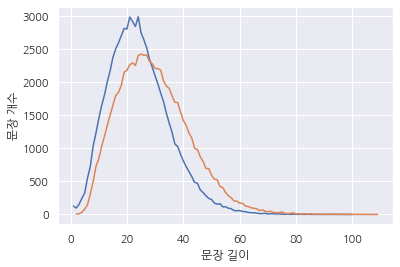

In [11]:
cp_train["pre_ko_len"] = cp_train["pre_ko"].apply(lambda x: len(x))
cp_train["pre_en_len"] = cp_train["pre_en"].apply(lambda x: len(x))
print(f"짧거나 긴 문장 제거 전 데이터 개수 : {cp_train.shape[0]}")

cp_train.groupby("pre_ko_len").count().iloc[:,0].plot()
cp_train.groupby("pre_en_len").count().iloc[:,0].plot()
plt.xlabel("문장 길이")
plt.ylabel("문장 개수")
plt.show()

짧거나 긴 문장 제거 후 데이터 개수 : 54441


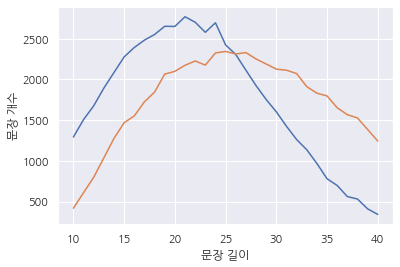

In [12]:
cp_train = cp_train[(cp_train["pre_ko_len"] <= 40) & (cp_train["pre_ko_len"] >= 10)].reset_index(drop=True)
cp_train = cp_train[(cp_train["pre_en_len"] <= 40) & (cp_train["pre_en_len"] >= 10)].reset_index(drop=True)
print(f"짧거나 긴 문장 제거 후 데이터 개수 : {cp_train.shape[0]}")

cp_train.groupby("pre_ko_len").count().iloc[:,0].plot()
cp_train.groupby("pre_en_len").count().iloc[:,0].plot()
plt.xlabel("문장 길이")
plt.ylabel("문장 개수")
plt.show()

### 3.2 SentencePiece 본 모델 구축

#### 영어와 한국어 SentencePiece model, vocab 구축

In [13]:
model_type = "bpe"
data = cp_train["ko"]
SRC_VOCAB_SIZE = 10000

add = False
train_test = "train_ko"
temp_file = "./spm_ko_train.tmp"

ko_spm = utils.SentencePiece(model_type, 
                             data, 
                             SRC_VOCAB_SIZE, 
                             add, 
                             train_test, 
                             temp_file)

In [14]:
model_type = "bpe"
data = cp_train["en"]
TGT_VOCAB_SIZE = 10000
add = False
train_test = "train_en"
temp_file = "./spm_en_train.tmp"

en_spm = utils.SentencePiece(model_type, 
                             data, 
                             TGT_VOCAB_SIZE, 
                             add, 
                             train_test, 
                             temp_file)

#### 구축된 SPM모델로 토큰화

In [15]:
# spm에 있는 토큰을 인코딩하면 ("", <bos>)이런식으로 나오기에 ""부분 제거
token_blank = en_spm.EncodeAsIds("<bos>")[0]
cp_train["pre_ko"] = cp_train["ko"].apply(lambda x: ko_spm.encode_as_ids(x))
cp_train["pre_ko"] = cp_train["pre_ko"].apply(lambda x: list(filter((token_blank).__ne__,x)))

cp_train["pre_en"] = cp_train["en"].apply(lambda x: en_spm.encode_as_ids(x))
cp_train["pre_en"] = cp_train["pre_en"].apply(lambda x: list(filter((token_blank).__ne__,x)))

### 모든 데이터를 길이 40인 문장으로 패딩

- 패딩 토큰의 id는 1입니다.

In [96]:
x_train = pad_sequences(cp_train["pre_ko"], 
                        maxlen = 40,
                        value = 1,
                        padding = "post")
y_train = pad_sequences(cp_train["pre_en"], 
                        maxlen = 40, 
                        value = 1,
                        padding = "post")

x_train, y_train, x_train.shape, y_train.shape

(array([[1358, 8960,  973, ...,    1,    1,    1],
        [ 445,  622, 8899, ...,    1,    1,    1],
        [ 249,   44,    6, ..., 6527,   20,    1],
        ...,
        [ 177,  129, 9222, ...,    1,    1,    1],
        [ 647, 8912, 2341, ...,    1,    1,    1],
        [ 443,  647, 8912, ...,    1,    1,    1]], dtype=int32),
 array([[   4, 1083,   38, ...,    1,    1,    1],
        [   4,  391,    7, ...,    1,    1,    1],
        [   4, 6195, 7308, ...,    1,    1,    1],
        ...,
        [   4,  174,   11, ...,    1,    1,    1],
        [   4, 1127,   47, ...,    1,    1,    1],
        [   4,  320,  147, ...,    1,    1,    1]], dtype=int32),
 (54441, 40),
 (54441, 40))

In [97]:
np.random.seed(100)
x_train = np.concatenate([x_train, x_train])
np.random.shuffle(x_train)
np.random.seed(100)
y_train = np.concatenate([y_train, y_train])
np.random.shuffle(y_train)

### 검증 데이터에도 훈련 데이터에 적용한 부분 똑같이 적용

In [98]:
cp_dev["pre_ko"] = cp_dev["ko"].apply(lambda x: ko_spm.encode_as_ids(x))
cp_dev["pre_ko"] = cp_dev["pre_ko"].apply(lambda x: list(filter((token_blank).__ne__,x)))
cp_dev["pre_en"] = cp_dev["en"].apply(lambda x: en_spm.encode_as_ids(x))
cp_dev["pre_en"] = cp_dev["pre_en"].apply(lambda x: list(filter((token_blank).__ne__,x)))

cp_dev["pre_ko_len"] = cp_dev["pre_ko"].apply(lambda x: len(x))
cp_dev["pre_en_len"] = cp_dev["pre_en"].apply(lambda x: len(x))

cp_dev = cp_dev[cp_dev["pre_ko_len"] <= 40].reset_index(drop=True)
cp_dev = cp_dev[cp_dev["pre_en_len"] <= 40].reset_index(drop=True)

x_dev = pad_sequences(cp_dev["pre_ko"], 
                      maxlen = 40, 
                      value = 1,
                      padding = "post")
y_dev = pad_sequences(cp_dev["pre_en"], 
                      maxlen = 40, 
                      value = 1,
                      padding = "post")

x_dev, y_dev, x_dev.shape, y_dev.shape

(array([[1008, 1291, 2453, ...,    1,    1,    1],
        [ 152, 2197,    6, ...,    1,    1,    1],
        [2695,  253, 9064, ...,    1,    1,    1],
        ...,
        [ 881, 8855, 8875, ...,    1,    1,    1],
        [2053,  706, 3375, ...,    1,    1,    1],
        [1577, 1722, 9514, ...,    1,    1,    1]], dtype=int32),
 array([[   4,  778, 1109, ...,    1,    1,    1],
        [   4,   11, 1755, ...,    1,    1,    1],
        [   4,   93,  349, ...,    1,    1,    1],
        ...,
        [   4,  645, 9994, ...,    1,    1,    1],
        [   4,  523,  497, ...,    0,    5,    1],
        [   4, 2390, 8279, ...,    1,    1,    1]], dtype=int32),
 (771, 40),
 (771, 40))

## Step 4. 모델 설계

In [99]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc) 
        h_dec = tf.expand_dims(h_dec, 1) # [batch, 1, units]
        h_dec = self.w_dec(h_dec)
        
        # score shape : [batch, length, units]
        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        # attn shape : [batch, length, 1]
        attn = tf.nn.softmax(score, axis=1)
        
        # context_vec.shape : [batch, length, units]
        context_vec = attn * h_enc
        # context_vec.shape : [batch, units]
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [100]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        # embedding shape : [batch, length, embedding_dim]
        out = self.embedding(x) 
        # gru shape : [batch, length, enc_units]
        out = self.gru(out) 
        
        return out

In [101]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.bn = tf.keras.layers.BatchNormalization()
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)
    # 학습과정에서 문장이 통째로가 아닌 문장에 있는 한 단어씩 들어옴 (batch, 1)
    def call(self, x, h_dec, enc_out):
        # enc_out.shape = [batch, length, units]
        # h_dec shape = [batch, units]
        context_vec, attn = self.attention(enc_out, h_dec) # context_vec.shape : [batch, units]
        
        out = self.embedding(x) # out shape = [batch, 1, embedding_dim]
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1) # out shape = [batch, 1, embedding_dim + units]
        out, h_dec = self.gru(out) # out shape = [batch, 1, units]
        out = self.bn(out)
        out = tf.reshape(out, (-1, out.shape[2])) # out shape = [batch, units]
        out = self.fc(out) # out shape = [batch, vocab_size]
        return out, h_dec, attn

In [102]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

## Step 5. 훈련하기

In [103]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        # encode_as_ids('<bos>') = (9970, 4)[-1] => 4
        dec_src = tf.expand_dims([dec_tok.encode_as_ids('<bos>')[-1]] * bsz, 1)
        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [104]:
@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.encode_as_ids('<bos>')[-1]] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss

In [105]:
def evaluate(sentence, encoder, decoder, enc_tok, dec_tok):
    attention = np.zeros((y_train.shape[-1], x_train.shape[-1]))
    
    
    inputs = [ko_spm.EncodeAsIds(sentence)]
    inputs = pad_sequences(inputs, 
                           maxlen = 40, 
                           value = 1,
                           padding = "pre")
    result = ''
    
    # enc_out : [batch, length, units]
    enc_out = encoder(inputs)
    
    # dec_hidden : [batch, units]
    dec_hidden = enc_out[:, -1]
    # dec_input : [batch, 1]
    dec_input = tf.expand_dims([enc_tok.encode_as_ids('<bos>')[-1]], 0)

    for t in range(y_train.shape[-1]):
        # predictions : [batch, vocab_size]
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()
        
        # predicted_id : numpy.int64
        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()
        result += dec_tok.DecodeIds([int(predicted_id)]) + ' '

        if dec_tok.DecodeIds([int(predicted_id)]) == '<eos>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder, enc_tok, dec_tok):
    result, sentence, attention = evaluate(sentence, encoder, decoder, enc_tok, dec_tok)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
#    attention = attention[:len(result.split()), :len(sentence.split())]
#    plot_attention(attention, sentence.split(), result.split(' '))
# translate("나는 배가 고프다", encoder, decoder, ko_spm, en_spm)

In [106]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 30
BATCH_SIZE = 128


units = 256
embedding_dim = 100

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

history_train_loss = []
history_test_loss = []
for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, x_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(x_train[idx:idx+BATCH_SIZE],
                                y_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                en_spm)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    
    test_loss = 0
    
    idx_list = list(range(0, x_dev.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(x_dev[idx:idx+BATCH_SIZE],
                                    y_dev[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    en_spm)
    
        test_loss += test_batch_loss
    
        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

    history_train_loss += [total_loss.numpy()]
    history_test_loss += [test_loss.numpy()]
    
    sentence = "오바마는 대통령이다."
    translate(sentence, encoder, decoder, ko_spm, en_spm)
    sentence = "시민들은 도시 속에 산다."
    translate(sentence, encoder, decoder, ko_spm, en_spm)
    sentence = "커피는 필요 없다."
    translate(sentence, encoder, decoder, ko_spm, en_spm)
    sentence = "일곱 명의 사망자가 발생했다."
    translate(sentence, encoder, decoder, ko_spm, en_spm)    

Test Epoch  1: 100%|██████████| 7/7 [00:24<00:00,  3.49s/it, Test Loss 4.7933]


Input: 오바마는 대통령이다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Input: 시민들은 도시 속에 산다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Input: 커피는 필요 없다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


Test Epoch  2: 100%|██████████| 7/7 [00:00<00:00, 10.13it/s, Test Loss 4.7821]


Input: 오바마는 대통령이다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Input: 시민들은 도시 속에 산다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Input: 커피는 필요 없다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


Test Epoch  3: 100%|██████████| 7/7 [00:00<00:00, 10.10it/s, Test Loss 4.7722]


Input: 오바마는 대통령이다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Input: 시민들은 도시 속에 산다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Input: 커피는 필요 없다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


Test Epoch  4: 100%|██████████| 7/7 [00:00<00:00, 10.17it/s, Test Loss 4.7783]


Input: 오바마는 대통령이다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Input: 시민들은 도시 속에 산다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Input: 커피는 필요 없다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


Test Epoch  5: 100%|██████████| 7/7 [00:00<00:00, 10.17it/s, Test Loss 4.7763]


Input: 오바마는 대통령이다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Input: 시민들은 도시 속에 산다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Input: 커피는 필요 없다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


Test Epoch  6: 100%|██████████| 7/7 [00:00<00:00, 10.09it/s, Test Loss 4.7759]


Input: 오바마는 대통령이다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Input: 시민들은 도시 속에 산다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Input: 커피는 필요 없다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


Test Epoch  7: 100%|██████████| 7/7 [00:00<00:00, 10.06it/s, Test Loss 4.7745]


Input: 오바마는 대통령이다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Input: 시민들은 도시 속에 산다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
Input: 커피는 필요 없다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


Test Epoch  8: 100%|██████████| 7/7 [00:00<00:00, 10.08it/s, Test Loss 4.1322]


Input: 오바마는 대통령이다.
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
Input: 커피는 필요 없다.
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


Test Epoch  9: 100%|██████████| 7/7 [00:00<00:00, 10.07it/s, Test Loss 3.9479]


Input: 오바마는 대통령이다.
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
Input: 커피는 필요 없다.
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


Test Epoch 10: 100%|██████████| 7/7 [00:00<00:00, 10.14it/s, Test Loss 3.8956]


Input: 오바마는 대통령이다.
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
Input: 시민들은 도시 속에 산다.
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 
Input: 커피는 필요 없다.
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


Test Epoch 11: 100%|██████████| 7/7 [00:00<00:00, 10.19it/s, Test Loss 3.7133]


Input: 오바마는 대통령이다.
Predicted translation: the year of the year of the year of the year of the year of the year of the year of the year of the year of the year of the year of the year of the year of the 
Input: 시민들은 도시 속에 산다.
Predicted translation: the year of the year of the year of the year of the year of the year of the year of the year of the year of the year of the year of the year of the year of the 
Input: 커피는 필요 없다.
Predicted translation: the year of the year of the year of the year of the year of the year of the year of the year of the year of the year of the year of the year of the year of the 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the year of the year of the year of the year of the year of the year of the year of the year of the year of the year of the year of the year of the year of the 


Test Epoch 12: 100%|██████████| 7/7 [00:00<00:00, 10.17it/s, Test Loss 3.6244]


Input: 오바마는 대통령이다.
Predicted translation: the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the 
Input: 시민들은 도시 속에 산다.
Predicted translation: the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the 
Input: 커피는 필요 없다.
Predicted translation: the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the first of the 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the first year of the first year of the first year of the first year of the first year of the first year of the first year of the first year of the first year of the first year of 


Test Epoch 13: 100%|██████████| 7/7 [00:00<00:00, 10.13it/s, Test Loss 3.4941]


Input: 오바마는 대통령이다.
Predicted translation: the first time <eos> 
Input: 시민들은 도시 속에 산다.
Predicted translation: the first time <eos> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 커피는 필요 없다.
Predicted translation: the first time <eos> 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the country <eos> 


Test Epoch 14: 100%|██████████| 7/7 [00:00<00:00, 10.16it/s, Test Loss 3.3749]


Input: 오바마는 대통령이다.
Predicted translation: the two time <eos> 
Input: 시민들은 도시 속에 산다.
Predicted translation: the two day <eos> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 커피는 필요 없다.
Predicted translation: the two people were a statement <eos> 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two people were a statement <eos> 


Test Epoch 15: 100%|██████████| 7/7 [00:00<00:00, 10.05it/s, Test Loss 3.2516]


Input: 오바마는 대통령이다.
Predicted translation: the government <eos> 
Input: 시민들은 도시 속에 산다.
Predicted translation: the government <eos> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 커피는 필요 없다.
Predicted translation: the government <eos> 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the government <eos> 


Test Epoch 16: 100%|██████████| 7/7 [00:00<00:00,  9.83it/s, Test Loss 3.1253]


Input: 오바마는 대통령이다.
Predicted translation: the government <eos> 
Input: 시민들은 도시 속에 산다.
Predicted translation: the government <eos> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 커피는 필요 없다.
Predicted translation: the government <eos> 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the government <eos> 


Test Epoch 17: 100%|██████████| 7/7 [00:00<00:00, 10.07it/s, Test Loss 3.0091]


Input: 오바마는 대통령이다.
Predicted translation: the national party is also is also is the national party is also is also is the national party is also is also is the national party is also is also is the national party is also is also is 
Input: 시민들은 도시 속에 산다.
Predicted translation: the national party is also is also is the two years ago ' s office also is also is the two years ago ' s office also is also is the two years ago ' s office also is also 
Input: 커피는 필요 없다.
Predicted translation: the ap ' s office also is also is the national security department is also is the national security department is also is the national security department is also is the national security department is also is the national security 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the national party is also has been also have been a new cnn is also has been also have been a new cnn is also has been also have been a new cnn is also has been also have been 


Test Epoch 18: 100%|██████████| 7/7 [00:00<00:00, 10.12it/s, Test Loss 2.9333]


Input: 오바마는 대통령이다.
Predicted translation: the government is also is a year ago <eos> 
Input: 시민들은 도시 속에 산다.
Predicted translation: the government is also is a year <eos> 
Input: 커피는 필요 없다.
Predicted translation: the government is also have been a year ago <eos> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two years ago , the two years ago , the two years ago , the two years ago , the two years ago , the two years ago , the two years ago , the two years ago , 


Test Epoch 19: 100%|██████████| 7/7 [00:00<00:00, 10.05it/s, Test Loss 2.8902]


Input: 오바마는 대통령이다.
Predicted translation: the government is also have a year <eos> 
Input: 시민들은 도시 속에 산다.
Predicted translation: the government is also have been a year <eos> 
Input: 커피는 필요 없다.
Predicted translation: the government is also say <eos> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the government is also reported <eos> 


Test Epoch 20: 100%|██████████| 7/7 [00:00<00:00, 10.13it/s, Test Loss 2.8833]


Input: 오바마는 대통령이다.
Predicted translation: the associated press <eos> 
Input: 시민들은 도시 속에 산다.
Predicted translation: the ap reported <eos> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 커피는 필요 없다.
Predicted translation: the associated press <eos> 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the associated press <eos> 


Test Epoch 21: 100%|██████████| 7/7 [00:00<00:00, 10.20it/s, Test Loss 2.8950]


Input: 오바마는 대통령이다.
Predicted translation: the associated press reported <eos> 
Input: 시민들은 도시 속에 산다.
Predicted translation: the associated press reported <eos> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 커피는 필요 없다.
Predicted translation: the associated press reported <eos> 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the associated press reported <eos> 


Test Epoch 22: 100%|██████████| 7/7 [00:00<00:00, 10.15it/s, Test Loss 2.9077]


Input: 오바마는 대통령이다.
Predicted translation: the associated press <eos> 
Input: 시민들은 도시 속에 산다.
Predicted translation: the associated press <eos> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 커피는 필요 없다.
Predicted translation: the associated press <eos> 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the associated press <eos> 


Test Epoch 23: 100%|██████████| 7/7 [00:00<00:00, 10.23it/s, Test Loss 2.9468]


Input: 오바마는 대통령이다.
Predicted translation: the is also reported <eos> 
Input: 시민들은 도시 속에 산다.
Predicted translation: the is also reported <eos> 
Input: 커피는 필요 없다.
Predicted translation: the is also reported <eos> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two leaders have been a iling in the debris <eos> 


Test Epoch 24: 100%|██████████| 7/7 [00:00<00:00, 10.12it/s, Test Loss 2.9794]


Input: 오바마는 대통령이다.
Predicted translation: the two leaders have been a iling <eos> 
Input: 시민들은 도시 속에 산다.
Predicted translation: the two leaders have been a iling street <eos> 
Input: 커피는 필요 없다.
Predicted translation: the two leaders have been a iling <eos> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two leaders have been a iling ing a navy <eos> 


Test Epoch 25: 100%|██████████| 7/7 [00:00<00:00,  9.93it/s, Test Loss 3.0245]


Input: 오바마는 대통령이다.
Predicted translation: the two sides also reported <eos> 
Input: 시민들은 도시 속에 산다.
Predicted translation: the two sides also reported <eos> 
Input: 커피는 필요 없다.
Predicted translation: the two sides also reported <eos> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two sides have been seen in the latest public ized <eos> 


Test Epoch 26: 100%|██████████| 7/7 [00:00<00:00, 10.06it/s, Test Loss 3.0847]


Input: 오바마는 대통령이다.
Predicted translation: the two sides have been trying to be seen a iling <eos> 
Input: 시민들은 도시 속에 산다.
Predicted translation: the two sides have been a tent ill ing street <eos> 
Input: 커피는 필요 없다.
Predicted translation: the two sides have been trying to be extrad ite igan <eos> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two sides have been seen a third farewell to land age <eos> 


Test Epoch 27: 100%|██████████| 7/7 [00:00<00:00, 10.13it/s, Test Loss 3.1664]


Input: 오바마는 대통령이다.
Predicted translation: the is also to be seen as a iling <eos> 
Input: 시민들은 도시 속에 산다.
Predicted translation: the is also to be seen a tent ipe for a tent ipe ing ing ing ing ing ing ing ing ing ing ing ing ing ing ing ing ing ing ing ing ing ing ing ing ing ing ing 
Input: 커피는 필요 없다.
Predicted translation: the is also to take place <eos> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the is also to take place <eos> 


Test Epoch 28: 100%|██████████| 7/7 [00:00<00:00, 10.14it/s, Test Loss 3.2192]


Input: 오바마는 대통령이다.
Predicted translation: the order is the plan <eos> 
Input: 시민들은 도시 속에 산다.
Predicted translation: the order is the plan <eos> 
Input: 커피는 필요 없다.
Predicted translation: the order is the latest incident <eos> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the order is the latest press break maj its <eos> 


Test Epoch 29: 100%|██████████| 7/7 [00:00<00:00, 10.10it/s, Test Loss 3.2835]


Input: 오바마는 대통령이다.
Predicted translation: the two leaders have been taking place <eos> 
Input: 시민들은 도시 속에 산다.
Predicted translation: the two leaders have been in the latest attempt to mark uff le <eos> 
Input: 커피는 필요 없다.
Predicted translation: the two leaders have been trying to be no place in place <eos> 


  0%|          | 0/851 [00:00<?, ?it/s]

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the two leaders have been trying to have gotten a truck ing <eos> 


Test Epoch 30: 100%|██████████| 7/7 [00:00<00:00, 10.27it/s, Test Loss 3.3436]


Input: 오바마는 대통령이다.
Predicted translation: the amount of the time is the latest surprise <eos> 
Input: 시민들은 도시 속에 산다.
Predicted translation: the amount of the amount of the time <eos> 
Input: 커피는 필요 없다.
Predicted translation: the amount of the amount of the time <eos> 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the amount of the associated press <eos> 


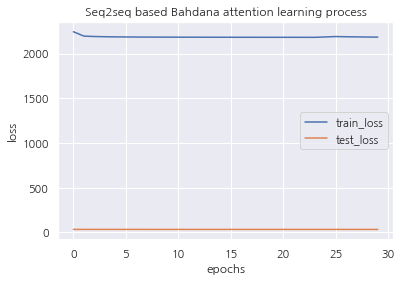

In [26]:
plt.plot(history_train_loss, label = "train_loss")
plt.plot(history_test_loss, label = "test_loss")
plt.legend()
plt.title("Seq2seq based Bahdana attention learning process")
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()